# Get BFCs from the list of annotated commits
They will be stored in `BFCs['estimated']`

In [139]:
import os
import pandas as pd

annotations_dir = "comparison-3"
annotations_dir = "commit-annotator"
reviews_dir = "comparison-3"

def get_BFCs(results_df):
    df = results_df[['hash', 'bfc']]
    return df

def read_csv_from_dir(dirname, filename):
    results = pd.read_csv(os.path.join('..', dirname, filename))
    return results
    
results_A = read_csv_from_dir(annotations_dir, 'annotations_Michel.csv')
results_B = read_csv_from_dir(annotations_dir, 'annotations_Abhishek.csv')
results_C = read_csv_from_dir(annotations_dir, 'annotations_David.csv')

BFCs_A = get_BFCs(results_A)
BFCs_B = get_BFCs(results_B)
BFCs_C = get_BFCs(results_C)

BFCs = pd.merge(BFCs_A, BFCs_B, on='hash', how='inner', suffixes=('A', 'B'))

BFCs = pd.merge(BFCs, BFCs_C, on='hash', how='inner', suffixes=('', 'C'))
BFCs = BFCs[['hash', 'bfcA', 'bfcB', 'bfc']]
BFCs = BFCs.rename(columns={'bfc': 'bfcC'})

In [140]:
BFCs_R = read_csv_from_dir(reviews_dir, 'review_jesus.csv')
BFCs = pd.merge(BFCs, BFCs_R, on='hash', how='left')
BFCs['bfcR'] = BFCs['bfc']
BFCs = BFCs[['hash', 'bfcA', 'bfcB', 'bfcC', 'bfcR']]

In [141]:
import math

def estimation(A, B, C, R):
    if math.isnan(R):
        return round((A + B + C) / 3)
    else:
        return R
BFCs['estimation'] = BFCs.apply(lambda row: estimation(row['bfcA'], row['bfcB'], row['bfcC'], row['bfcR']), axis=1) 

In [142]:
BFCs['estimation'].value_counts()

estimation
0.0    697
4.0    184
3.0     11
2.0     10
1.0      9
Name: count, dtype: int64

# Get commits in LTS branches

In [143]:
LTS_commits = pd.read_csv('upstream_commits.csv', converters={'branch': str})
LTS_commits['hash'] = LTS_commits['commit'].str[:10]
print(f"Upstream commits found: {len(LTS_commits)}")
print(f"Unique upstream commits found: {len(LTS_commits['hash'].unique())}")

Upstream commits found: 277523
Unique upstream commits found: 90908


# Merge and analyze annotated commits found in LTS branches

In [144]:
LTS_annotated = pd.merge(LTS_commits, BFCs, on='hash', how='left')
#LTS_annotated['estimation'].value_counts()

In [145]:
commit_url = "https://git.kernel.org/pub/scm/linux/kernel/git/torvalds/linux.git/commit/?id={hash}"

LTS_annotated = LTS_annotated[LTS_annotated['estimation'].notna()]
LTS_annotated['link'] = LTS_annotated['commit'].apply(lambda hash: "<a href='" + commit_url.format(hash=hash) + "'>Link</a>")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#LTS_annotated

branch  estimation
4.1     4.0           57
        0.0           24
        1.0            4
        2.0            2
        3.0            2
4.14    4.0           26
        0.0            8
        1.0            2
        2.0            1
        3.0            1
4.19    4.0           31
        0.0           16
        1.0            2
        2.0            1
        3.0            1
4.9     4.0           20
        0.0            5
        1.0            1
        2.0            1
        3.0            1
5.10    4.0           64
        0.0           27
        1.0            4
        2.0            2
        3.0            1
5.15    4.0           92
        0.0           42
        1.0            4
        2.0            2
        3.0            1
5.4     4.0           40
        0.0           20
        1.0            2
        2.0            2
        3.0            1
6.1     0.0           14
        4.0            9
        1.0            1
        2.0            1
      

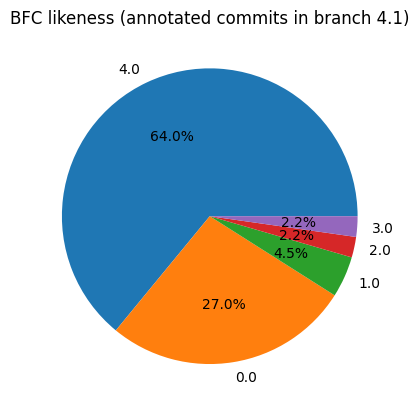

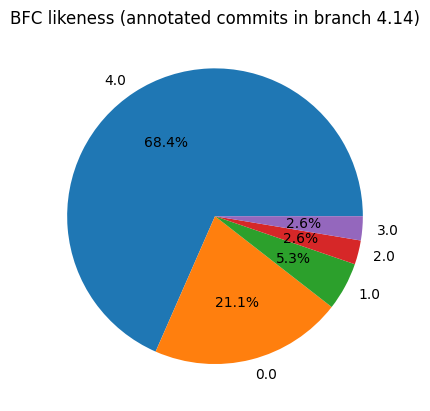

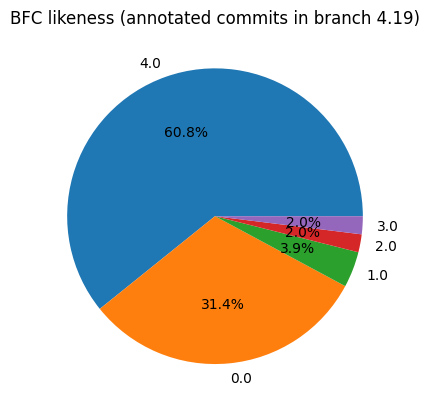

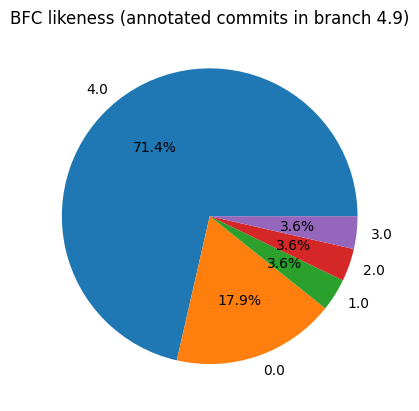

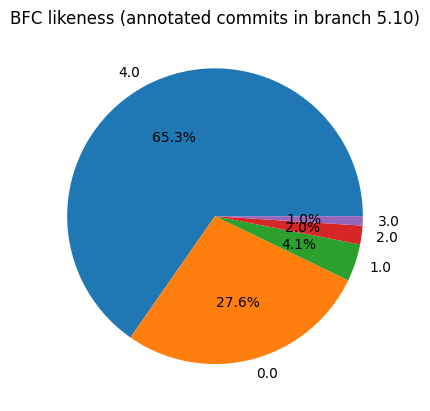

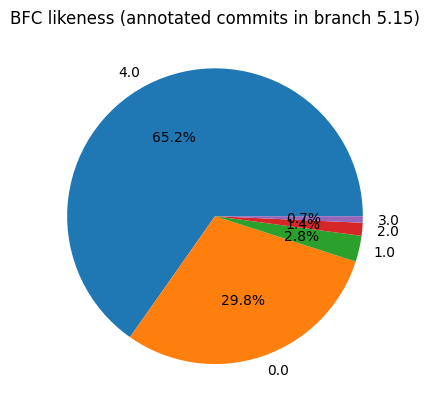

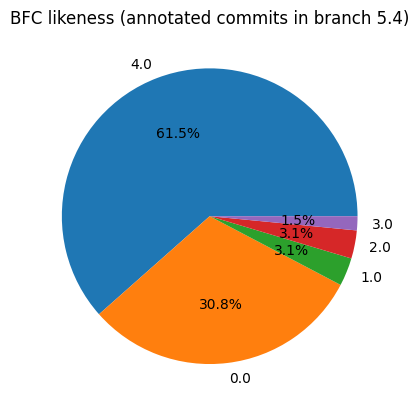

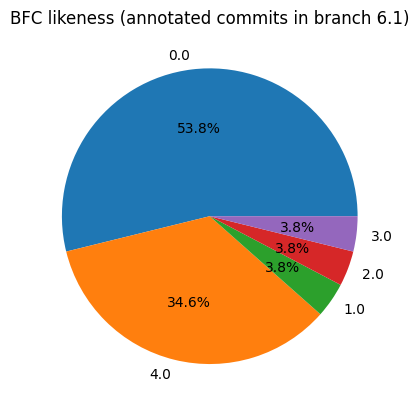

In [146]:
import matplotlib.pyplot as plt
#import seaborn as sns

bfc_counts = LTS_annotated.groupby('branch')['estimation'].value_counts()
display(bfc_counts)

for value in bfc_counts.index.levels[0]:
    plt.figure()
    plt.pie(bfc_counts.loc[value], labels=bfc_counts.loc[value].index, autopct='%1.1f%%')
    plt.title(f'BFC likeness (annotated commits in branch {value})')
    plt.show()

In [147]:
from IPython.display import HTML

HTML(LTS_annotated.to_html(escape=False))
#HTML(LTS_annotated.loc[LTS_annotated['estimation'] < 4, :].to_html(escape=False))

,branch,commit,hash,bfcA,bfcB,bfcC,bfcR,estimation,link
9593,6.1,f0052d7a1edb3d8921b4e154aa8c46c4845b3714,f0052d7a1e,0.0,0.0,0.0,NaN,0.0,Link
10345,6.1,2c1eafc40e53312864bf2fdccb55052dcbd9e8b2,2c1eafc40e,0.0,0.0,0.0,NaN,0.0,Link
10347,6.1,59a811faa74f4326fe2d48d2b334c0ee95922628,59a811faa7,0.0,0.0,0.0,NaN,0.0,Link
10604,6.1,65ea840afd508194b0ee903256162aa87e46ec30,65ea840afd,1.0,4.0,0.0,NaN,2.0,Link
11014,6.1,994b7ac1697b4581b7726d2ac64321e3c840229b,994b7ac169,0.0,0.0,0.0,NaN,0.0,Link
12270,6.1,d23417a5bf3a3afc55de5442eb46e1e60458b0a1,d23417a5bf,4.0,4.0,4.0,NaN,4.0,Link
12549,6.1,3ffa9f713c39a213a08d9ff13ab983a8aa5d8b5d,3ffa9f713c,4.0,4.0,4.0,NaN,4.0,Link
12829,6.1,0ca18d09c744fb030ae9bc5836c3e357e0237dea,0ca18d09c7,1.0,0.0,0.0,NaN,0.0,Link
12850,6.1,c65234b283a65cfbfc94619655e820a5e55199eb,c65234b283,4.0,4.0,4.0,NaN,4.0,Link
12926,6.1,bedcf9d1dcf88ed38731f0ac9620e5a421e1e9d6,bedcf9d1dc,0.0,0.0,0.0,NaN,0.0,Link
